In [337]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re

# Statistics
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo

# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [338]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [339]:
data = pd.read_csv('Data/1Channel.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]
n

array([105])

In [340]:
def Gauss(x,mean=1,sigma=0.1):
    return norm.pdf(x,loc=mean,scale=sigma)

In [341]:
def Prior(mu,e):

    if np.isscalar(mu) and np.isscalar(e):
        if mu > 0 and e > 0 and e < 10:
            return 1.
        else:
            return 0.
    else:
        if np.all(mu > 0) and np.all( e > 0) and np.all( e < 10 ):
            return 1.
        else:
            return 0.

In [362]:
def Likelihood(mu,e,n,b,s):

    lambda_ = mu*s + e*b

    log_likelihood = -lambda_ + n * np.log( lambda_ ) - gammaln( n+1 )
    Like = np.exp(log_likelihood)

    # Sistematic
    # Consideramos un ancho de 5% del background
    GausLike = Gauss( e , mean = 1., sigma = 0.4 )

    return Like*GausLike

In [363]:
def JointLikelihood(mu,e,n,b,s):

    Like = 1.0

    for c in range(N):
        Like *= Likelihood(mu,e,n[c],b[c],s[c])

    Like *= Prior(mu,e)
    
    return Like

In [364]:
JointLikelihood(0.5,1.,n,b,s)

0.038799025136826454

In [365]:
mu = np.linspace(0.01,5,30)
e = np.linspace(0.01,2,30)
Mu,E = np.meshgrid(mu,e)
Surface = np.zeros_like(Mu)

for i in range(len(mu)):
    for j in range(len(e)):
        Surface[i,j] = JointLikelihood(mu[i],e[j],n,b,s)

Text(0, 0.5, '$\\epsilon$')

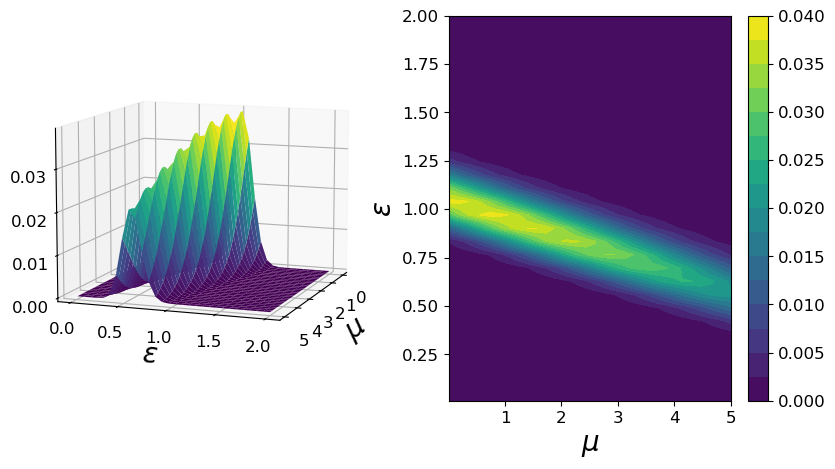

In [380]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, projection='3d', elev = 10, azim = 20)
ax.plot_surface(Mu,E,Surface.T, cmap='viridis')

ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\epsilon$')

ax1 = fig.add_subplot(1,2,2)
c = ax1.contourf(Mu,E,Surface.T,15,cmap='viridis')
fig.colorbar(c,ax=ax1)

ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$\epsilon$')

In [381]:
# Calculando la normalizacion de la posterior
Normalization = integrate.dblquad( JointLikelihood, 0.01, np.inf, 0.01, np.inf, args=(n,b,s) )[0]
Normalization

0.05499391876037821

In [382]:
# Aca vamos a crear la distribución posterior
def Marginal(e,mu,n,b,s):
    return JointLikelihood(mu,e,n,b,s)

In [383]:
# Ahora vamos a encontrar la distribución posterior marginal
mu = np.linspace(0.01,4,20)

Posterior = np.zeros_like(mu)

for i in range(len(mu)):
    Posterior[i] = integrate.quad( Marginal, 0.01, np.inf, args=(mu[i],n,b,s) )[0]

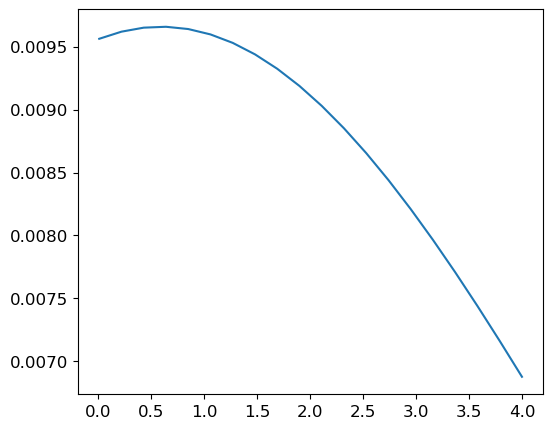

In [384]:
plt.plot(mu,Posterior)